# Eaters world

Scroll down to the "Start here" cell.



Like PACMAN where *eaters* 


we've got this move to food program but its dumb, only senses whats around it
this is a problem, the eater will stop when theres nothing immediately around it

p53 pic of not knowing what to do 




In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../src/')

from lib.pysoarlib import *
import os
from random import choice, randint

# Visualization
from PIL import Image, ImageDraw, ImageFont
from IPython import display
from time import sleep

# Current working directory (.../tutorials)
cwd = os.path.abspath('')
font_sm = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSansMono.ttf", 14, encoding="unic")

In [3]:
class Food():
    def __init__(self, bonus=False):
        self.points = 10   if bonus else 5
        self.color = 'red' if bonus else 'blue'
        self.bonus = bonus
    def __repr__(self):
        return 'bonusfood' if self.bonus else 'normalfood'
    
    
class Blank():
    def __init__(self):
        pass
    def __repr__(self):
        return 'blank'

    
class Wall():
    def __init__(self):
        pass
    def __repr__(self):
        return 'wall'
    
class GridBuilder:
    def __init__(self, world_type, rows, cols):
        self.rows = rows
        self.cols = cols
        self.grid = [[Blank() for x in range(cols)] for y in range(rows)] 
        
        if world_type == 'all food':
            self._add_random_food()
        elif world_type == 'random':
            # Initialize grid with walls/blank squares
            self._add_random_walls()
            # Fill the rest with food
            self._add_random_food(blank_only=True)
        else:
            raise Exception("Unknown world type")

    def get_iter(self):
        flatten = lambda t: [item for sublist in t for item in sublist]
        return flatten([[(row, col) for col in range(self.cols)] for row in range(self.rows)] )

    def _add_random_walls(self):
        choices = [Wall(), Blank(), Blank(), Blank(), Blank()]
        for row, col in self.get_iter():
            self.grid[row][col] = choice(choices)
        
    def _add_random_food(self, blank_only=False):
        for row, col in self.get_iter():
            if (blank_only and isinstance(self.grid[row][col], Blank)) or not blank_only:
                self.grid[row][col] = choice([Food(bonus=True), Food(bonus=False)])
     
    
# action_space = ['north', 'east', 'south', 'west']
class World():    
    def __init__(self, display, world_type, width=300, height=300, rows=16, cols=16):
        self.n_rows = rows
        self.n_cols = cols
        self.width = width
        self.height = height
        
        builder = GridBuilder(world_type, rows, cols)
        self.grid = builder.grid

            
            
        self.image = Image.new("RGBA", (self.width, self.height), (255, 255, 255, 0))
        self.canvas = ImageDraw.Draw(self.image)
        self.display = display
        self.cell_w = self.width / cols
        self.cell_h = self.width / rows
        
    def place_eaters(self, eaters):
        # Place the eaters randomly
        for eater in eaters:
            while True:
                row, col = randint(0, self.n_rows - 1), randint(0, self.n_cols - 1)
                if not isinstance(self.grid[row][col], Wall):
                    self.grid[row][col] = eater
                    break

    def step(self, ID: str, action = None):
        """ Returns (observations, reward) """
        ((row_n, col_n), cell) = self.find(ID)
        
        new_row = row_n
        new_col = col_n
        if action == 'north': new_row -= 1
        if action == 'south': new_row += 1
        if action == 'west' : new_col -= 1
        if action == 'east' : new_col += 1
        
        no_move = new_row == row_n and new_col == col_n
        if not self.is_valid_move(new_row, new_col) or no_move:
            # Don't move and return current observations
            return self.observations(row_n, col_n), 0
        
        if self.is_collision((row_n, col_n), (new_row, new_col)):
            raise Exception("no logic to handle collisions")
        else:        
            # aka reward
            points = 0
            if hasattr(self.grid[new_row][new_col], 'points'):
                points = self.grid[new_row][new_col].points
            self.grid[new_row][new_col] = self.grid[row_n][col_n]
            self.grid[row_n][col_n] = Blank()
            return self.observations(new_row, new_col), points


    def is_valid_move(self, row, col):
        # Out of bounds
        if row < 0 or col < 0 or row >= self.n_rows or col >= self.n_cols:
            return False
        is_wall = isinstance(self.grid[row][col], Wall)
        return not is_wall
        
    def is_collision(self, pos1, pos2):
        eater_1 = self.grid[pos1[0]][pos1[1]]
        eater_2 = self.grid[pos2[0]][pos2[1]]
        return isinstance(eater_1, Eater) and isinstance(eater_2, Eater) and eater_1.ID != eater_2.ID
        
    def observations(self, row, col):
        north = '' if row == 0           else self.grid[row - 1][col]
        south = '' if row >= self.n_rows-1 else self.grid[row + 1][col]
        east = ''  if col >= self.n_cols-1 else self.grid[row][col + 1]
        west = ''  if col == 0           else self.grid[row][col - 1]
        return {
            'north' : str(north),
            'south' : str(south),
            'east'  : str(east),
            'west'  : str(west),
        }
    
    def find(self, ID: str): 
        for row_n, row in enumerate(self.grid):
            for col_n, cell in enumerate(row):
                if hasattr(cell, 'ID') and cell.ID == ID:
                    return ((row_n, col_n), cell)
        raise Exception(f"Couldn't find {ID}")
        
    def draw(self):
        for y, row in enumerate(self.grid):
            for x, cell in enumerate(row):
                rect = (x * self.cell_w, y * self.cell_h, self.cell_w, self.cell_h)
                if isinstance(cell, Blank):
                    self._draw_rect(rect, fill='white')
                if isinstance(cell, Wall):
                    self._draw_rect(rect, fill='black')
                if isinstance(cell, Eater):
                    self._draw_rect(rect, fill=cell.color)
                    self._center_text(rect, font_sm, str(cell.points))
                if isinstance(cell, Food):
                    padding = .30 * self.cell_w
                    x_pos, y_pos = x * self.cell_w + padding, y * self.cell_h + padding
                    w = self.cell_w - (padding * 2)
                    h = self.cell_h - (padding * 2)
                    self._draw_circle((x_pos, y_pos, w, h), fill=cell.color)
        
        self.display.update(self.image)
    
    ####### Private
    def _draw_circle(self, bg, fill: str, outline: str = 'black'):
        x, y, width, height = bg
        self.canvas.ellipse((x, y, x + width, y + height), fill = fill, outline = outline)

    def _draw_rect(self, bg, fill: str):
        x, y, width, height = bg
        self.canvas.rectangle((x, y, x + width, y + height), fill=fill)
        
    def _center_text(self, bg, font, text, color=(0, 0, 0)):
        x, y, width, height = bg
        text_width, text_height = self.canvas.textsize(text, font)
        position = ((width - text_width)/2 + x, (height - text_height)/2 + y)
        self.canvas.text(position, text, color, font=font)

Propose food is looking for

```
(state <s> ^io.input-link.location.<dir>.content 
    << normalfood bonusfood >>)
```

In [4]:
class Eater():
    def __init__(self, ID: str, agent_raw: str, world: World, watch_level=1):
        """ Initialize eater. ID works as the color too. """
        self.ID = ID
        self.color = ID
        self.points = 0
        self.agent = SoarAgent(
            agent_name=f"agent_{ID}",
            write_to_stdout=True,
            agent_raw=agent_raw,
            watch_level=watch_level,
        )
        self.connector = MoveConnector(self.agent)
        self.agent.add_connector("eater", self.connector)
        self.agent.connect()
        
    def step(self):
        self.agent.execute_command("step")

    def get_move(self):
        move = self.connector.last_move_output
        self.connector.last_move_output = None
        return move
        
    def update_wm_from_observations(self, coords, observations):
        (x, y) = coords
        self.connector.x.set_value(x)
        self.connector.y.set_value(y)
        for (direction, contents) in observations.items():
            # Example: connector.contents['north'].set_value('bonusfood')
            self.connector.contents[direction].set_value(contents)
        
        
class MoveConnector(AgentConnector):
    def __init__(self, agent):
        AgentConnector.__init__(self, agent)
        self.move_command = "move"
        self.add_output_command(self.move_command)
        self.last_move_output = None
        self.location_id = None
        self.eater_id = None
        self.x = SoarWME('x', -1)
        self.y = SoarWME('y', -1)
        self.directions = { 'north': None, 'south': None, 'east': None, 'west': None }
        # content is "bonusfood" | "normalfood" | "wall" | "blank"
        self.contents = {}
        for direction in self.directions.keys():
            self.contents[direction] = SoarWME('content', '')
            

    def on_input_phase(self, input_link):
        # Intialize WM elements on the input-link
        if self.eater_id is None or self.location_id is None:
            if self.eater_id is None:
                self.eater_id = input_link.CreateIdWME('eater')
                self.x.add_to_wm(self.eater_id)
                self.y.add_to_wm(self.eater_id)

            if self.location_id is None:
                self.location_id = input_link.CreateIdWME('location')
                for direction in self.directions.keys():
                    # Add a <direction> identifier on the location identifier
                    self.directions[direction] = self.location_id.CreateIdWME(direction)
                    # Add the ^contents attribute to the direction
                    # Accessing this in full would look like location.north.content
                    self.contents[direction].add_to_wm(self.directions[direction])
            return
        
        self.x.update_wm()
        self.y.update_wm()
        
        # If the value has changed, will update soar's working memory with the new value
        for direction, contents in self.contents.items():
            """ TODO i should be removing this, right? i can't tell if the tutorial visual-soar is programmed
            to do this (meaning i should too)
            p.65
            "Unlike the move-north operator, these proposal rules do not have to test the coordinates of the 
            eater because the contents of the neighboring cells will change when the eater moves. The contents 
            will change (the working memory elements for contents of all of the sensed cells are removed and 
            re-added to working memory) even if the sensed object is the same type."
            
            removing and adding back does not seem to work, though.
            The move_to_food agent will move correctly for awhile, but then, if it gets stuck,
            it will move to a blank space. This shouldn't happen.
            """
#             contents.remove_from_wm()
#             contents.add_to_wm(self.directions[direction])
            contents.update_wm()

    def on_output_event(self, command_name, root_id):
        if command_name == self.move_command:
            self.process_move_command(root_id)
    
    def process_move_command(self, root_id):
        direction = root_id.GetChildString("direction")
        self.last_move_output = direction
        root_id.AddStatusComplete()

In [5]:
def runner(
    eaters, 
    world_type='random', 
    debug=False, 
    total_ticks=100, 
    tick_speed=1, 
    soar_watch_level=0,
    display_world=True, 
    debug_output_link=False,
):
    """
    param eaters:
        list of tuples (color, Soar script)
    """
    d = display.display("z", display_id=True)

    world = World(d, world_type, width=600, height=600, rows=16, cols=16)
    eaters = [Eater(color, script, world, watch_level=soar_watch_level) for (color, script) in eaters]
    world.place_eaters(eaters)

    # Set intial eater WM
    for e in eaters:
        pos, cell = world.find(e.ID)    
        observations = world.observations(pos[0], pos[1])
        e.update_wm_from_observations(pos, observations)
        e.step()
        
    debug_on = debug
    debug = lambda x: print(x) if debug_on else 0

    if display_world:
        world.draw()
    
    for i in range(total_ticks):
        debug('==============================================================================')
        debug('==============================================================================')
        debug(f'============================== WORLD TICK {i} ==================================')
        debug('==============================================================================')
        debug('==============================================================================')
        
        for eater in eaters:            
            ### Get observations
            pos, cell = world.find(eater.ID)    
            observations = world.observations(pos[0], pos[1])
            debug(f'\t>>>>>>>>> Eater "{eater.ID}"\'s observations: {observations}')
            
            ### Update eater
            eater.update_wm_from_observations(pos, observations)
            # Propose new move operator
            eater.step()
            # Apply new move operator, triggering an output link
            eater.step()
                
            ### Take action
            action = eater.get_move()
            debug(f'\t>>>>>>>>> Eater "{eater.ID}" chose action {action}')
            
            # TODO: Not sure why adding this makes it work
            # Have to set these to null so that there isn't a 'state no change'
            eater.update_wm_from_observations((-1, -1), {
                'north': 'null',
                'south': 'null',
                'east': 'null',
                'west': 'null',
            })
            
            if debug_output_link:
                print(f'\t>>>>>>>>> Eater "{eater.ID}" output-link')
                eater.agent.execute_command("print --depth 2 i3", print_res=True)
            
            _, reward = world.step(eater.ID, action)
            eater.points += reward

        if display_world:
            world.draw()
            
        sleep(tick_speed) 

In [6]:
simple_move_to_food_agent = """
sp {propose*move-to-food
   (state <s> ^io.input-link.location.<dir>.content 
                 << normalfood bonusfood >>)
-->
   (<s> ^operator <o> + =)
   (<o> ^name move-to-food
        ^direction <dir>)}

sp {apply*move-to-food
   (state <s> ^io.output-link <ol>
              ^operator <o>)
   (<o> ^name move-to-food
        ^direction <dir>)
-->
   (<ol> ^move.direction <dir>)}

sp {apply*move-to-food*remove-move
   (state <s> ^io.output-link <ol>
              ^operator.name move-to-food)
   (<ol> ^move <move>)
   (<move> ^status complete)
-->
   (<ol> ^move <move> -)}
"""

simple_move_to_food_with_monitoring = simple_move_to_food_agent + """
sp {eater*monitor*directions
    (state <s> ^io.input-link.location.<dir>.content <item>)
-->
    (write (crlf) <dir> | <<<<has item>>>> | <item>)}
"""

# Start Here

TODO explain eater world

Run the cell below a few times to see a simple eater in action.

All this eater does is sense the four squares around it. 
If one of the squares contains food, it moves towards it.
Notice how these simple rules will cause an eater to get stuck if it cannot sense any food.

This will run for 100 ticks (seconds) if you don't do anything. Press the stop button to halt the program once the eaters have settled.

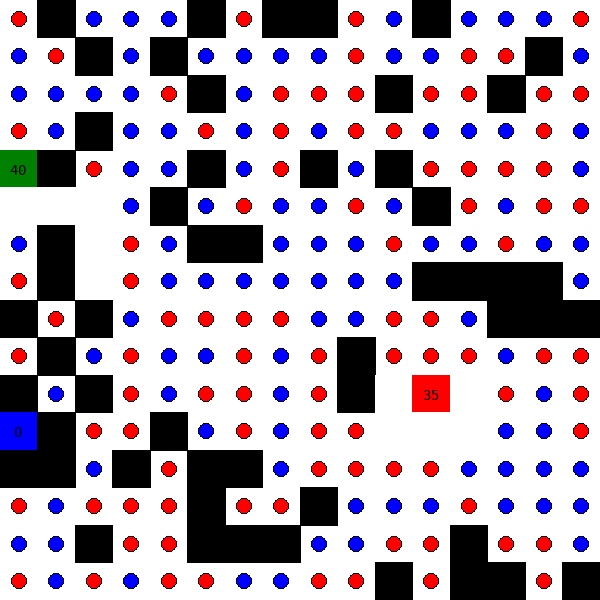

--------- SOURCING PRODUCTIONS ------------
Total: 3 productions sourced.
--------- SOURCING PRODUCTIONS ------------
Total: 3 productions sourced.
--------- SOURCING PRODUCTIONS ------------
Total: 3 productions sourced.


KeyboardInterrupt: 

In [7]:
eaters = [
    ('blue', simple_move_to_food_agent),
    ('red', simple_move_to_food_agent),
    ('green', simple_move_to_food_agent),
]

runner(eaters)

## Let's write it ourselves!

So far, our agents haven't interacted with the outside world at all. They have only maintained an internal state that we populated manually. 
Using what we know now, we couldn't create a robot that moved through an office building to give a stapler to an employee.
That would require *sensing* walls around it, *moving* using some path finder algorithm, and some *hand-stapler* mechanism that guided the robot arm to place a stapler on a desk.
In Soar, you'd program the logic `if I have a stapler, and <target> is infront of me, hand them the stapler, else move to target` into the agent. 
You *wouldn't* program the actual *moving* or *sensing* however. This is because Soar is a kernel.

#### The kernel

Soar clarifies that it is *not* an all purposed AI machine. Soar is a "kernel". The linux kernel, for example, isn't a full-fledged operating system. It doesn't have a GUI. It doesn't have a text editor you can use to edit files using a mouse and keyboard. It does, however, provide hooks for someone to build these things ontop of it. It manages low level process scheduling, memory management, and security. 

You can think of Soar in a similar fashion. Soar won't give you a nice library for recognizing objects from a camera feed or for moving a robot from one location to another with A*. It does, however, give you hooks to send information to the agent (I sense a wall infront of me) for internal planning and reasoning. 
If rules were to fire for `wall infront` and `wall infront of me is bad` then you can have another hook to listen to that event and modify your agents real world position using the robot's motor system.

#### IO

Sending information to a Soar agent is done through an `input-link`. Receiving commands from a Soar agent is done through an `output-link`.

In this section, we'll talk about the two phases of the Soar cycle we left out in the last lesson: input and output phase.

TODO picture of the soar cycle


#### Jargon you may come across

`Sensors / perception mechanism` Anything that gives an agent information about the outside world. For example, in the eaters world, we provide the agent with the perception of the food around it. If this was a robotics problem in the real world, our sensor could be a camera. We could perform object recognition from the camera feed then send that information (object name, position, etc) to the Soar agent.

`Actuators` How agents perform actions to modify the world around them.

### Output Link

Let's begin by writing an agent that just moves in one direction. 

We can accomplish this task with two rules: `propose*move-north`, `apply*move-north`.

```
propose*move-north
If I exist, 
then propose the move-north operator.

apply*move-north
If the move-north operator is selected, 
then generate an output command to move north.
```

Soar agents have an object in WM called `io`. 
This `io` object has two children, `input-link` and `output-link`.
We can add to the `output-link` as a way of creating commands.
In this case, our command is `move`. 
Our `move` can store information itself, like the speed at which we want to move, or direction.

In `apply*move-north`, we want to create this `move` object on the `output-link` with the `direction` as `north`.

![Output link](./img/3_output-link-north.png)

#### Exercise

Try writing the above two rules to propose and apply the `move-north` operator.

In [ ]:
my_move_north_operators = """
sp {propose*move-north 
    # Code here
}

sp {apply*move-north
    # Code here
}
"""

eaters = [('blue', my_move_north_operators)]
# If you have trouble and want to debug, set the soar_watch_level to a number like 3 or 5
# Debug=True will print each world tick and observations for each eater
runner(eaters, soar_watch_level=5, debug=False, total_ticks=4, world_type='all food')

### This space is intentionally left blank to hide the answers

---


### This space is intentionally left blank to hide the answers

---

### This space is intentionally left blank to hide the answers

---


### This space is intentionally left blank to hide the answers

---

### This space is intentionally left blank to hide the answers

---


### This space is intentionally left blank to hide the answers

---

In [ ]:
answer_move_north_operators = """
sp {propose*move-north 
    (state <s> ^type state)
-->
    (<s> ^operator <o> +) 
    (<o> ^name move-north)}

sp {apply*move-north
    (state <s> ^operator <o>
               ^io <io>) 
    (<io> ^output-link <out>)
    (<o> ^name move-north) 
-->
    (<out> ^move <move>) 
    (<move> ^direction north)}
"""

answer_move_north_operators_condense_notation = """
sp {propose*move-north 
    (state <s> ^type state)
-->
    (<s> ^operator <o> +) 
    (<o> ^name move-north)}

sp {apply*move-north
    (state <s> ^operator.name move-north
               ^io.output-link <out>) 
-->
    (<out> ^move.direction north)}
"""

eaters = [('blue', answer_move_north_operators_condense_notation)]
runner(eaters, total_ticks=3, tick_speed=.1, world_type='all food')

Our eater moves... once.

Let's review the rules.

**Propose**
```
sp {propose*move-north 
    (state <s> ^type state)
-->
    (<s> ^operator <o> +) 
    (<o> ^name move-north)}
```
Nothing special here: on state, propose a new operator named `move-north`.

**Apply**
```
sp {apply*move-north
    (state <s> ^operator <o>
               ^io <io>)        # ^io must be matched to get to the output-link
    (<io> ^output-link <out>)   # ^output-link gives path to identifier for action
    (<o> ^name move-north) 
-->
    (<out> ^move <move>)        # Add command to output-link to move north
    (<move> ^direction north)}
```
(See the above *condensed* version for a more succinct way to write the same thing.)

We've seen the whole `match a state to an operator named "my-operator"` before. 
Above, the new addition is matching on a state with an `io` object (and subsequently throwing that into the `<io>` variable).
We then see if our matched `<io>` has the attribute `^output-link`.

In the "then" portion, we add an object to the `<out>` output-link. 
This object is a command named `move` that carries additional information about the direction in which the agent wants to move.

If you go into the `Eater` class provided to you, you'll see that we are initializing an agent connector. The connector handles the logic for listening to commands named `move`.

```
self.move_command = "move"
self.add_output_command(self.move_command)
```

Once that has been added, whenever the agent adds `move` to the `output-link`, the following function will be called.

```
def on_output_event(self, command_name, root_id):
    if command_name == self.move_command:
        direction = root_id.GetChildString("direction")
        self.last_move_output = direction
        root_id.AddStatusComplete()
```

In our Soar rule, when we add `move` to the `output-link`, we also add `direction` to `move`. 
The line `direction = root_id.GetChildString("direction")` saves the value of the `direction` object into a variable.

Finally, we save the move output for later. In `runner` there is simple loop that takes the output and applies it to the world. Here is the loop in full:

**1. Get observations**

Get the items to the north, south, east, and west of the eater.

**2. Update eater**

Add these observations to the `input-link` of the eater. 
The eater will update its internal state given the new observations.

**3. Take action**

If the eater has created a `move` an `output-link`, take the move direction and apply it to the world.
If the move is valid, the world will update.

In [ ]:
# TODO it may be nice to show how to add an input link and listen to output commands using the 
# .execute_command function

## Move-North: Making Multiple Moves

So why did the eater only take one step north? Why didn't it continue?

To the Soar agent, nothing provoked the need to move again. We propose to move for the sole condition `(state <s> ^type state)`. 
Once we move again, nothing has changed to the Soar agent. 
*We* see that it's moved, but *it* doesn't know that it has. 
What we want to do instead is give the Soar agent fresh information once it moves so it knows whether or not to move again.

#### Design Principle: One to One Firings

In Soar, it is recommended to design your agents to select operators (like move) **once** per **operator instance**.

We added a move operator instance in our `propose*move-north` rule...
```
    (<s> ^operator <o> +) 
    (<o> ^name move-north)}
```
...that created one operator instance.

What we want is to **design the eater so that a new instance of the move-north operator is created for each move**.

TODO Unsure the best way to explain *why* for this ^^

What we can do for now is give Soar it's X Y coordinates on the grid.
Then, whenever those coordinates change, we can make the eater move again.
In our simple example, the agent will move until it hits the boundaries of the world.
It then won't keep going because its state of the world (X Y coordinates) won't change.

Looks look at the rule.
```
sp {propose*move-north
    (state <s> ^io.input-link.eater <e>) 
    (<e> ^x <x> ^y <y>)
-->
    (<s> ^operator <o> +) 
    (<o> ^name move-north)}
```

In the first condition, we're checking to see if the state has an `input-link` with `eater` on it. The second condition checks if there is an `x` and `y`.

In [ ]:
move_north_operators_with_x_y = """
sp {propose*move-north
    (state <s> ^io.input-link.eater <e>) 
    (<e> ^x <x> ^y <y>)
-->
    (<s> ^operator <o> +) 
    (<o> ^name move-north)}

# This is the same as before
sp {apply*move-north
    (state <s> ^operator <o>
               ^io <io>) 
    (<io> ^output-link <out>)
    (<o> ^name move-north) 
-->
    (<out> ^move <move>) 
    (<move> ^direction north)}
"""

eaters = [('blue', move_north_operators_with_x_y)]
runner(eaters, total_ticks=20, tick_speed=.25, world_type='all food')

Remember our discussion about `instantiation supported`/`operator supported` memory? 

#### Refresher

Memory who's lifetime is dependent on the rule that created it is called `i-support`. When the contents for water jug changes, the old rule matching the old contents **retracts**. Soar then fires a *new* rule for the *new* contents which in turn creates a *new* `empty` working memory element.

Memory that persists long after it's parent rule has retracted is `o-support` memory. 
If a rule with an operator matches (`(state <s> ^operator.name initialize-water-jug)`) and if that rule then modifies state (`(<s> ^name water-jug ^jug <j1> ^jug <j2>)`) it will be persistent. This is because in Soar, *persistent working memory can only be created through operator rules*.

#### Okay, so what happened?

Our new `move-north` rule is *dependent solely on the state and the X Y coordinates*, therefore it is in the `i-support` camp.
When X or Y changes, the current `move-north` rule doesn't *exactly match* the new state. The current rule *retracts* and a new rule fires.

#### Debugger

Let's look at what the debugger shows us.

In [ ]:
eaters = [('blue', move_north_operators_with_x_y)]
runner(eaters, total_ticks=5, debug=True, world_type='all food', soar_watch_level=5, display_world=False)

`<=` Removal from WM

`=>` Addition to WM

`=> (NUMBER: I3 ^move M2)`

number indicates the *timetag* of the working memory element.


TODO this is a bit dependent on getting the update_wm correct in the runner, debugger doesn't match exactly the Soar tutorial

Now, we're only going to look at what is happening on `output-link` (`debug_output_link=True`).

In [ ]:
eaters = [('blue', move_north_operators_with_x_y)]
runner(eaters, total_ticks=3, tick_speed=.1, world_type='all food', display_world=False, debug_output_link=True)

After 3 ticks, our `output-link` has accumulated a bunch of move commands. 
These commands will continue to pile on the `output-link` unless we manually specify their removal.

Let's look at our rule that created these `move` commands in WM.
After looking at the rule, don't read further until you answered the question: is this rule in the `o-support` or `i-support` camp?

```
sp {apply*move-north
    (state <s> ^operator.name move-north
               ^io.output-link <out>) 
-->
    (<out> ^move.direction north)}
```

Blank space to hiding answer.

Blank space to hiding answer.

Blank space to hiding answer.

Blank space to hiding answer.

Blank space to hiding answer.

IwishInewAwaytoHideAnswersInNoteBooksbutThisisAnOSupportRule because it tested a selected operator and modified the state.

So how do we remove the old commands? 
Because we are going to persitently make an update to state,
we have to ensure we do the removal during an operator application rule. 

Notice how the `^status complete` to the completed move commands. 
If you look at the code for the eater's AgentConnector, you'll find that we manually mark the output command's status to be complete.

```
def process_move_command(self, root_id):
    # Can ignore this part for now
    direction = root_id.GetChildString("direction")
    self.last_move_output = direction
    
    root_id.AddStatusComplete() # <<<<<<<<
```

This is where you would write/call any actuator code (move the robot arm to place a stapler on a desk).

We can write a rule to remove completed moves from WM in an operator application rule.

In [ ]:
remove_completed_move = """
sp {apply*move-north*remove-move
    (state <s> ^operator.name move-north
               ^io.output-link <out>) 
    (<out> ^move <move>)
    (<move> ^status complete) 
-->
    (<out> ^move <move> -)}
"""

eaters = [('blue', move_north_operators_with_x_y + remove_completed_move)]
runner(eaters, total_ticks=3, tick_speed=.1, world_type='all food', display_world=False, debug_output_link=True)

In the "then" part of the rule, we remove the matched `output-link` that has a completed `<move>` from WM using the `-` sign (aka the **reject preference**). 
And because `^status complete` and `^direction` were both children of the move command object, they get removed too.

Since this was an operator application rule, it is fired during the "Operator Application" phase.

![soar cycle](img/3_soar-cycle-with-support-labels.png)

Remember that Soar fires rules in parallel, so the `apply*move-north` and `apply*move-north*remove-move` will happen at the same time (remove old move command, add new move command).

TODO Good quote to add somewhere (p64)
> From prior runs, you know that I3 is the identifier of the output-link. Although Soar does not guarantee that I3 will always be the identifier of the output-link, it always is, just as I1 is the identifier of the io object, I2 is the identifier of the input-link, and S1 is the identifier of the first state.

## Move-To-Food Operator 

You should now have the knowledge to write the rules for the first agent we saw: the move-to-food agent.

Instead of testing the `input-link` for an eater (`(state <s> ^io.input-link.eater <e>)`), you'll want to test the `input-link` for the food around the agent (`(state <s> ^io.input-link.location.north/south/east/west.content`).
The `content` will either be `normalfood` or `bonusfood`.

#### Exercise

Write the following rules:
1. (propose) If normalfood is by me, propose I move-to-food in that direction.
2. (propose) If bonusfood is by me, propose I move-to-food in that direction.
3. (apply) If the move-to-food operator is selected, create an output command to move in that direction.
4. (apply) If the move-to-food operator is selected and there's an existing completed move command, remove it.

Things to keep in mind:
* To keep things simple, have `1` and `2` *indifferently* propose the operator so that the agent chooses where to move *at random*. Remember that if you don't specifiy this indifference, an impasse will be thrown.


Extra credit:
1. Combine `1` and `2` into a single rule using disjunctions as disucssed in the previous tutorial.
2. Write a monitor rule that prints out the contents of the cells around the agent.

In [ ]:
exercise_move_to_food_agent = """

"""

eaters = [
    ('blue', exercise_move_to_food_agent),
#     ('red', exercise_move_to_food_agent), add more eaters if you want
]

runner(eaters, debug=True, soar_watch_level=5)

### This space is intentionally left blank to hide the answers

---


### This space is intentionally left blank to hide the answers

---

### This space is intentionally left blank to hide the answers

---


### This space is intentionally left blank to hide the answers

---

### This space is intentionally left blank to hide the answers

---


### This space is intentionally left blank to hide the answers

---

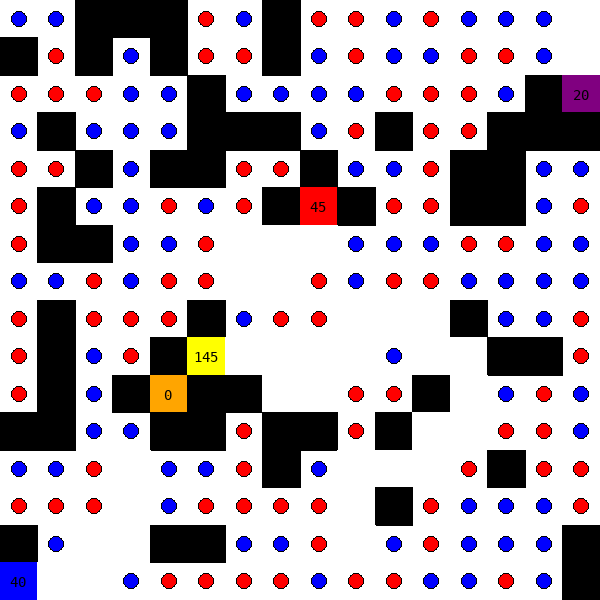

--------- SOURCING PRODUCTIONS ------------
Total: 5 productions sourced.
--------- SOURCING PRODUCTIONS ------------
Total: 3 productions sourced.
--------- SOURCING PRODUCTIONS ------------
Total: 4 productions sourced.
--------- SOURCING PRODUCTIONS ------------
Total: 4 productions sourced.
--------- SOURCING PRODUCTIONS ------------
Total: 4 productions sourced.
--- Input Phase ---
=>WM: (25: W1 ^content bonusfood)
=>WM: (24: L2 ^west W1)
=>WM: (23: E3 ^content normalfood)
=>WM: (22: L2 ^east E3)
=>WM: (21: I4 ^content normalfood)
=>WM: (20: L2 ^south I4)
=>WM: (19: N1 ^content normalfood)
=>WM: (18: L2 ^north N1)
=>WM: (17: I2 ^location L2)
=>WM: (16: E2 ^y 3)
=>WM: (15: E2 ^x 12)
=>WM: (14: I2 ^eater E2)

--- END Input Phase ---
--- Proposal Phase ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing propose*move-to-bonusfood

Firing eater*monitor*directions

west <<<<has item>>>> bonusfood
Firing propose*move-to-normalfood

Firing eater*monitor*directions

east <

============================== WORLD TICK 0 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'normalfood', 'south': 'normalfood', 'east': 'normalfood', 'west': 'bonusfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food
+ (M1 ^direction west +  :O ) (apply*move-to-food)
+ (I3 ^move M1 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
=>WM: (40: M1 ^direction west)
=>WM: (39: I3 ^move M1)

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (47: W1 ^content bonusfood)
=>WM: (46: E3 ^content normalfood)
=>WM: (45: I4 ^content normalfood)
=>WM: (44: N1 ^content normalfood)
=>WM: (43: E2 ^y 3)
=>WM: (42: E2 ^x 12)
=>WM: (41: M1 ^status complete)
<=WM: (25: W1 ^content bonusfood)
<=WM: (23: E3 ^content normalfood)
<=WM: (21: I4 ^content normalfood)
<=WM: (19: N1 ^content norma

============================== WORLD TICK 1 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'blank', 'south': 'normalfood', 'east': 'normalfood', 'west': 'bonusfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M2 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M2 ^direction south +  :O ) (apply*move-to-food)
<=WM: (61: M2 ^direction south)
<=WM: (63: M2 ^status complete)
<=WM: (62: I3 ^move M2)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (83: W1 ^content bonusfood)
=>WM: (82: E3 ^content normalfood)
=>WM: (81: I4 ^content normalfood)
=>WM: (80: N1 ^content blank)
=>WM: (79: E2 ^y 3)
=>

============================== WORLD TICK 2 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'blank', 'south': 'normalfood', 'east': 'wall', 'west': 'bonusfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M3 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M3 ^direction south +  :O ) (apply*move-to-food)
<=WM: (95: M3 ^direction south)
<=WM: (96: M3 ^status complete)
<=WM: (94: I3 ^move M3)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (116: W1 ^content bonusfood)
=>WM: (115: E3 ^content wall)
=>WM: (114: I4 ^content normalfood)
=>WM: (113: N1 ^content blank)
=>WM: (112: E2 ^y 3)
=>WM: (11

============================== WORLD TICK 3 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'bonusfood', 'south': 'bonusfood', 'east': 'blank', 'west': 'normalfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M4 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M4 ^direction west +  :O ) (apply*move-to-food)
<=WM: (125: M4 ^direction west)
<=WM: (126: M4 ^status complete)
<=WM: (124: I3 ^move M4)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (146: W1 ^content normalfood)
=>WM: (145: E3 ^content blank)
=>WM: (144: I4 ^content bonusfood)
=>WM: (143: N1 ^content bonusfood)
=>WM: (142: E2 ^y 2

============================== WORLD TICK 4 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'blank', 'south': '', 'east': 'normalfood', 'west': 'normalfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M5 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M5 ^direction south +  :O ) (apply*move-to-food)
<=WM: (158: M5 ^direction south)
<=WM: (159: M5 ^status complete)
<=WM: (157: I3 ^move M5)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (179: W1 ^content normalfood)
=>WM: (178: E3 ^content normalfood)
=>WM: (177: I4 ^content )
=>WM: (176: N1 ^content blank)
=>WM: (175: E2 ^y 2)
=>WM: (174: 

============================== WORLD TICK 5 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'normalfood', 'south': '', 'east': 'blank', 'west': 'normalfood'}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M6 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M6 ^direction west +  :O ) (apply*move-to-food)
<=WM: (188: M6 ^direction west)
<=WM: (189: M6 ^status complete)
<=WM: (187: I3 ^move M6)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (209: W1 ^content normalfood)
=>WM: (208: E3 ^content blank)
=>WM: (207: I4 ^content )
=>WM: (206: N1 ^content normalfood)
=>WM: (205: E2 ^y 1)
=>WM: (204: E2

============================== WORLD TICK 6 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': '', 'east': 'blank', 'west': ''}
--- Application Phase ---
	--- Firing Productions (PE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing apply*move-to-food*remove-move
- (I3 ^move M7 +  :O ) (apply*move-to-food)
	--- Change Working Memory (PE) ---
- (M7 ^direction west +  :O ) (apply*move-to-food)
<=WM: (218: M7 ^direction west)
<=WM: (219: M7 ^status complete)
<=WM: (217: I3 ^move M7)
	--- Firing Productions (IE) For State At Depth 1 ---

--- Inner Elaboration Phase, active level 1 goal S1 ---
	--- Change Working Memory (IE) ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (239: W1 ^content )
=>WM: (238: E3 ^content blank)
=>WM: (237: I4 ^content )
=>WM: (236: N1 ^content wall)
=>WM: (235: E2 ^y 0)
=>WM: (234: E2 ^x 15)
<=WM: (209: W1 ^content 

============================== WORLD TICK 7 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': '', 'east': 'blank', 'west': ''}
--- Application Phase ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (273: W1 ^content )
=>WM: (272: E3 ^content blank)
=>WM: (271: I4 ^content )
=>WM: (270: N1 ^content wall)
=>WM: (269: E2 ^y 0)
=>WM: (268: E2 ^x 15)
<=WM: (239: W1 ^content )
<=WM: (238: E3 ^content blank)
<=WM: (237: I4 ^content )
<=WM: (236: N1 ^content wall)
<=WM: (235: E2 ^y 0)
<=WM: (234: E2 ^x 15)

--- END Input Phase ---
--- Proposal Phase ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing eater*monitor*directions

north <<<<has item>>>> wall
Firing eater*monitor*directions

south <<<<has item>>>> 
Firing eater*monitor*directions

east <<<<has item>>>> blank
Firing eater*monitor*directions

west <<<<has item>>>> 
--- END Proposal Phase ---
--- Decision Phase

============================== WORLD TICK 8 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': '', 'east': 'blank', 'west': ''}
--- Application Phase ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (307: W1 ^content )
=>WM: (306: E3 ^content blank)
=>WM: (305: I4 ^content )
=>WM: (304: N1 ^content wall)
=>WM: (303: E2 ^y 0)
=>WM: (302: E2 ^x 15)
<=WM: (273: W1 ^content )
<=WM: (272: E3 ^content blank)
<=WM: (271: I4 ^content )
<=WM: (270: N1 ^content wall)
<=WM: (269: E2 ^y 0)
<=WM: (268: E2 ^x 15)

--- END Input Phase ---
--- Proposal Phase ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing eater*monitor*directions

north <<<<has item>>>> wall
Firing eater*monitor*directions

south <<<<has item>>>> 
Firing eater*monitor*directions

east <<<<has item>>>> blank
Firing eater*monitor*directions

west <<<<has item>>>> 
--- END Proposal Phase ---
--- Decision Phase

============================== WORLD TICK 9 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': '', 'east': 'blank', 'west': ''}
--- Application Phase ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (341: W1 ^content )
=>WM: (340: E3 ^content blank)
=>WM: (339: I4 ^content )
=>WM: (338: N1 ^content wall)
=>WM: (337: E2 ^y 0)
=>WM: (336: E2 ^x 15)
<=WM: (307: W1 ^content )
<=WM: (306: E3 ^content blank)
<=WM: (305: I4 ^content )
<=WM: (304: N1 ^content wall)
<=WM: (303: E2 ^y 0)
<=WM: (302: E2 ^x 15)

--- END Input Phase ---
--- Proposal Phase ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing eater*monitor*directions

north <<<<has item>>>> wall
Firing eater*monitor*directions

south <<<<has item>>>> 
Firing eater*monitor*directions

east <<<<has item>>>> blank
Firing eater*monitor*directions

west <<<<has item>>>> 
--- END Proposal Phase ---
--- Decision Phase

============================== WORLD TICK 10 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': '', 'east': 'blank', 'west': ''}
--- Application Phase ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (375: W1 ^content )
=>WM: (374: E3 ^content blank)
=>WM: (373: I4 ^content )
=>WM: (372: N1 ^content wall)
=>WM: (371: E2 ^y 0)
=>WM: (370: E2 ^x 15)
<=WM: (341: W1 ^content )
<=WM: (340: E3 ^content blank)
<=WM: (339: I4 ^content )
<=WM: (338: N1 ^content wall)
<=WM: (337: E2 ^y 0)
<=WM: (336: E2 ^x 15)

--- END Input Phase ---
--- Proposal Phase ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing eater*monitor*directions

north <<<<has item>>>> wall
Firing eater*monitor*directions

south <<<<has item>>>> 
Firing eater*monitor*directions

east <<<<has item>>>> blank
Firing eater*monitor*directions

west <<<<has item>>>> 
--- END Proposal Phase ---
--- Decision Phas

============================== WORLD TICK 11 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': '', 'east': 'blank', 'west': ''}
--- Application Phase ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (409: W1 ^content )
=>WM: (408: E3 ^content blank)
=>WM: (407: I4 ^content )
=>WM: (406: N1 ^content wall)
=>WM: (405: E2 ^y 0)
=>WM: (404: E2 ^x 15)
<=WM: (375: W1 ^content )
<=WM: (374: E3 ^content blank)
<=WM: (373: I4 ^content )
<=WM: (372: N1 ^content wall)
<=WM: (371: E2 ^y 0)
<=WM: (370: E2 ^x 15)

--- END Input Phase ---
--- Proposal Phase ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing eater*monitor*directions

north <<<<has item>>>> wall
Firing eater*monitor*directions

south <<<<has item>>>> 
Firing eater*monitor*directions

east <<<<has item>>>> blank
Firing eater*monitor*directions

west <<<<has item>>>> 
--- END Proposal Phase ---
--- Decision Phas

============================== WORLD TICK 12 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': '', 'east': 'blank', 'west': ''}
--- Application Phase ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (443: W1 ^content )
=>WM: (442: E3 ^content blank)
=>WM: (441: I4 ^content )
=>WM: (440: N1 ^content wall)
=>WM: (439: E2 ^y 0)
=>WM: (438: E2 ^x 15)
<=WM: (409: W1 ^content )
<=WM: (408: E3 ^content blank)
<=WM: (407: I4 ^content )
<=WM: (406: N1 ^content wall)
<=WM: (405: E2 ^y 0)
<=WM: (404: E2 ^x 15)

--- END Input Phase ---
--- Proposal Phase ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing eater*monitor*directions

north <<<<has item>>>> wall
Firing eater*monitor*directions

south <<<<has item>>>> 
Firing eater*monitor*directions

east <<<<has item>>>> blank
Firing eater*monitor*directions

west <<<<has item>>>> 
--- END Proposal Phase ---
--- Decision Phas

============================== WORLD TICK 13 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': '', 'east': 'blank', 'west': ''}
--- Application Phase ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (477: W1 ^content )
=>WM: (476: E3 ^content blank)
=>WM: (475: I4 ^content )
=>WM: (474: N1 ^content wall)
=>WM: (473: E2 ^y 0)
=>WM: (472: E2 ^x 15)
<=WM: (443: W1 ^content )
<=WM: (442: E3 ^content blank)
<=WM: (441: I4 ^content )
<=WM: (440: N1 ^content wall)
<=WM: (439: E2 ^y 0)
<=WM: (438: E2 ^x 15)

--- END Input Phase ---
--- Proposal Phase ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing eater*monitor*directions

north <<<<has item>>>> wall
Firing eater*monitor*directions

south <<<<has item>>>> 
Firing eater*monitor*directions

east <<<<has item>>>> blank
Firing eater*monitor*directions

west <<<<has item>>>> 
--- END Proposal Phase ---
--- Decision Phas

============================== WORLD TICK 14 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': '', 'east': 'blank', 'west': ''}
--- Application Phase ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (511: W1 ^content )
=>WM: (510: E3 ^content blank)
=>WM: (509: I4 ^content )
=>WM: (508: N1 ^content wall)
=>WM: (507: E2 ^y 0)
=>WM: (506: E2 ^x 15)
<=WM: (477: W1 ^content )
<=WM: (476: E3 ^content blank)
<=WM: (475: I4 ^content )
<=WM: (474: N1 ^content wall)
<=WM: (473: E2 ^y 0)
<=WM: (472: E2 ^x 15)

--- END Input Phase ---
--- Proposal Phase ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing eater*monitor*directions

north <<<<has item>>>> wall
Firing eater*monitor*directions

south <<<<has item>>>> 
Firing eater*monitor*directions

east <<<<has item>>>> blank
Firing eater*monitor*directions

west <<<<has item>>>> 
--- END Proposal Phase ---
--- Decision Phas

============================== WORLD TICK 15 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': '', 'east': 'blank', 'west': ''}
--- Application Phase ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (545: W1 ^content )
=>WM: (544: E3 ^content blank)
=>WM: (543: I4 ^content )
=>WM: (542: N1 ^content wall)
=>WM: (541: E2 ^y 0)
=>WM: (540: E2 ^x 15)
<=WM: (511: W1 ^content )
<=WM: (510: E3 ^content blank)
<=WM: (509: I4 ^content )
<=WM: (508: N1 ^content wall)
<=WM: (507: E2 ^y 0)
<=WM: (506: E2 ^x 15)

--- END Input Phase ---
--- Proposal Phase ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing eater*monitor*directions

north <<<<has item>>>> wall
Firing eater*monitor*directions

south <<<<has item>>>> 
Firing eater*monitor*directions

east <<<<has item>>>> blank
Firing eater*monitor*directions

west <<<<has item>>>> 
--- END Proposal Phase ---
--- Decision Phas

============================== WORLD TICK 16 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': '', 'east': 'blank', 'west': ''}
--- Application Phase ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (579: W1 ^content )
=>WM: (578: E3 ^content blank)
=>WM: (577: I4 ^content )
=>WM: (576: N1 ^content wall)
=>WM: (575: E2 ^y 0)
=>WM: (574: E2 ^x 15)
<=WM: (545: W1 ^content )
<=WM: (544: E3 ^content blank)
<=WM: (543: I4 ^content )
<=WM: (542: N1 ^content wall)
<=WM: (541: E2 ^y 0)
<=WM: (540: E2 ^x 15)

--- END Input Phase ---
--- Proposal Phase ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing eater*monitor*directions

north <<<<has item>>>> wall
Firing eater*monitor*directions

south <<<<has item>>>> 
Firing eater*monitor*directions

east <<<<has item>>>> blank
Firing eater*monitor*directions

west <<<<has item>>>> 
--- END Proposal Phase ---
--- Decision Phas

============================== WORLD TICK 17 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': '', 'east': 'blank', 'west': ''}
--- Application Phase ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (613: W1 ^content )
=>WM: (612: E3 ^content blank)
=>WM: (611: I4 ^content )
=>WM: (610: N1 ^content wall)
=>WM: (609: E2 ^y 0)
=>WM: (608: E2 ^x 15)
<=WM: (579: W1 ^content )
<=WM: (578: E3 ^content blank)
<=WM: (577: I4 ^content )
<=WM: (576: N1 ^content wall)
<=WM: (575: E2 ^y 0)
<=WM: (574: E2 ^x 15)

--- END Input Phase ---
--- Proposal Phase ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing eater*monitor*directions

north <<<<has item>>>> wall
Firing eater*monitor*directions

south <<<<has item>>>> 
Firing eater*monitor*directions

east <<<<has item>>>> blank
Firing eater*monitor*directions

west <<<<has item>>>> 
--- END Proposal Phase ---
--- Decision Phas

============================== WORLD TICK 18 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': '', 'east': 'blank', 'west': ''}
--- Application Phase ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (647: W1 ^content )
=>WM: (646: E3 ^content blank)
=>WM: (645: I4 ^content )
=>WM: (644: N1 ^content wall)
=>WM: (643: E2 ^y 0)
=>WM: (642: E2 ^x 15)
<=WM: (613: W1 ^content )
<=WM: (612: E3 ^content blank)
<=WM: (611: I4 ^content )
<=WM: (610: N1 ^content wall)
<=WM: (609: E2 ^y 0)
<=WM: (608: E2 ^x 15)

--- END Input Phase ---
--- Proposal Phase ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing eater*monitor*directions

north <<<<has item>>>> wall
Firing eater*monitor*directions

south <<<<has item>>>> 
Firing eater*monitor*directions

east <<<<has item>>>> blank
Firing eater*monitor*directions

west <<<<has item>>>> 
--- END Proposal Phase ---
--- Decision Phas

============================== WORLD TICK 19 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': '', 'east': 'blank', 'west': ''}
--- Application Phase ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (681: W1 ^content )
=>WM: (680: E3 ^content blank)
=>WM: (679: I4 ^content )
=>WM: (678: N1 ^content wall)
=>WM: (677: E2 ^y 0)
=>WM: (676: E2 ^x 15)
<=WM: (647: W1 ^content )
<=WM: (646: E3 ^content blank)
<=WM: (645: I4 ^content )
<=WM: (644: N1 ^content wall)
<=WM: (643: E2 ^y 0)
<=WM: (642: E2 ^x 15)

--- END Input Phase ---
--- Proposal Phase ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing eater*monitor*directions

north <<<<has item>>>> wall
Firing eater*monitor*directions

south <<<<has item>>>> 
Firing eater*monitor*directions

east <<<<has item>>>> blank
Firing eater*monitor*directions

west <<<<has item>>>> 
--- END Proposal Phase ---
--- Decision Phas

============================== WORLD TICK 20 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': '', 'east': 'blank', 'west': ''}
--- Application Phase ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (715: W1 ^content )
=>WM: (714: E3 ^content blank)
=>WM: (713: I4 ^content )
=>WM: (712: N1 ^content wall)
=>WM: (711: E2 ^y 0)
=>WM: (710: E2 ^x 15)
<=WM: (681: W1 ^content )
<=WM: (680: E3 ^content blank)
<=WM: (679: I4 ^content )
<=WM: (678: N1 ^content wall)
<=WM: (677: E2 ^y 0)
<=WM: (676: E2 ^x 15)

--- END Input Phase ---
--- Proposal Phase ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing eater*monitor*directions

north <<<<has item>>>> wall
Firing eater*monitor*directions

south <<<<has item>>>> 
Firing eater*monitor*directions

east <<<<has item>>>> blank
Firing eater*monitor*directions

west <<<<has item>>>> 
--- END Proposal Phase ---
--- Decision Phas

============================== WORLD TICK 21 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': '', 'east': 'blank', 'west': ''}
--- Application Phase ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (749: W1 ^content )
=>WM: (748: E3 ^content blank)
=>WM: (747: I4 ^content )
=>WM: (746: N1 ^content wall)
=>WM: (745: E2 ^y 0)
=>WM: (744: E2 ^x 15)
<=WM: (715: W1 ^content )
<=WM: (714: E3 ^content blank)
<=WM: (713: I4 ^content )
<=WM: (712: N1 ^content wall)
<=WM: (711: E2 ^y 0)
<=WM: (710: E2 ^x 15)

--- END Input Phase ---
--- Proposal Phase ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing eater*monitor*directions

north <<<<has item>>>> wall
Firing eater*monitor*directions

south <<<<has item>>>> 
Firing eater*monitor*directions

east <<<<has item>>>> blank
Firing eater*monitor*directions

west <<<<has item>>>> 
--- END Proposal Phase ---
--- Decision Phas

============================== WORLD TICK 22 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': '', 'east': 'blank', 'west': ''}
--- Application Phase ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (783: W1 ^content )
=>WM: (782: E3 ^content blank)
=>WM: (781: I4 ^content )
=>WM: (780: N1 ^content wall)
=>WM: (779: E2 ^y 0)
=>WM: (778: E2 ^x 15)
<=WM: (749: W1 ^content )
<=WM: (748: E3 ^content blank)
<=WM: (747: I4 ^content )
<=WM: (746: N1 ^content wall)
<=WM: (745: E2 ^y 0)
<=WM: (744: E2 ^x 15)

--- END Input Phase ---
--- Proposal Phase ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing eater*monitor*directions

north <<<<has item>>>> wall
Firing eater*monitor*directions

south <<<<has item>>>> 
Firing eater*monitor*directions

east <<<<has item>>>> blank
Firing eater*monitor*directions

west <<<<has item>>>> 
--- END Proposal Phase ---
--- Decision Phas

============================== WORLD TICK 23 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': '', 'east': 'blank', 'west': ''}
--- Application Phase ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (817: W1 ^content )
=>WM: (816: E3 ^content blank)
=>WM: (815: I4 ^content )
=>WM: (814: N1 ^content wall)
=>WM: (813: E2 ^y 0)
=>WM: (812: E2 ^x 15)
<=WM: (783: W1 ^content )
<=WM: (782: E3 ^content blank)
<=WM: (781: I4 ^content )
<=WM: (780: N1 ^content wall)
<=WM: (779: E2 ^y 0)
<=WM: (778: E2 ^x 15)

--- END Input Phase ---
--- Proposal Phase ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing eater*monitor*directions

north <<<<has item>>>> wall
Firing eater*monitor*directions

south <<<<has item>>>> 
Firing eater*monitor*directions

east <<<<has item>>>> blank
Firing eater*monitor*directions

west <<<<has item>>>> 
--- END Proposal Phase ---
--- Decision Phas

============================== WORLD TICK 24 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': '', 'east': 'blank', 'west': ''}
--- Application Phase ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (851: W1 ^content )
=>WM: (850: E3 ^content blank)
=>WM: (849: I4 ^content )
=>WM: (848: N1 ^content wall)
=>WM: (847: E2 ^y 0)
=>WM: (846: E2 ^x 15)
<=WM: (817: W1 ^content )
<=WM: (816: E3 ^content blank)
<=WM: (815: I4 ^content )
<=WM: (814: N1 ^content wall)
<=WM: (813: E2 ^y 0)
<=WM: (812: E2 ^x 15)

--- END Input Phase ---
--- Proposal Phase ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing eater*monitor*directions

north <<<<has item>>>> wall
Firing eater*monitor*directions

south <<<<has item>>>> 
Firing eater*monitor*directions

east <<<<has item>>>> blank
Firing eater*monitor*directions

west <<<<has item>>>> 
--- END Proposal Phase ---
--- Decision Phas

============================== WORLD TICK 25 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': '', 'east': 'blank', 'west': ''}
--- Application Phase ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (885: W1 ^content )
=>WM: (884: E3 ^content blank)
=>WM: (883: I4 ^content )
=>WM: (882: N1 ^content wall)
=>WM: (881: E2 ^y 0)
=>WM: (880: E2 ^x 15)
<=WM: (851: W1 ^content )
<=WM: (850: E3 ^content blank)
<=WM: (849: I4 ^content )
<=WM: (848: N1 ^content wall)
<=WM: (847: E2 ^y 0)
<=WM: (846: E2 ^x 15)

--- END Input Phase ---
--- Proposal Phase ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing eater*monitor*directions

north <<<<has item>>>> wall
Firing eater*monitor*directions

south <<<<has item>>>> 
Firing eater*monitor*directions

east <<<<has item>>>> blank
Firing eater*monitor*directions

west <<<<has item>>>> 
--- END Proposal Phase ---
--- Decision Phas

============================== WORLD TICK 26 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': '', 'east': 'blank', 'west': ''}
--- Application Phase ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (919: W1 ^content )
=>WM: (918: E3 ^content blank)
=>WM: (917: I4 ^content )
=>WM: (916: N1 ^content wall)
=>WM: (915: E2 ^y 0)
=>WM: (914: E2 ^x 15)
<=WM: (885: W1 ^content )
<=WM: (884: E3 ^content blank)
<=WM: (883: I4 ^content )
<=WM: (882: N1 ^content wall)
<=WM: (881: E2 ^y 0)
<=WM: (880: E2 ^x 15)

--- END Input Phase ---
--- Proposal Phase ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing eater*monitor*directions

north <<<<has item>>>> wall
Firing eater*monitor*directions

south <<<<has item>>>> 
Firing eater*monitor*directions

east <<<<has item>>>> blank
Firing eater*monitor*directions

west <<<<has item>>>> 
--- END Proposal Phase ---
--- Decision Phas

============================== WORLD TICK 27 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': '', 'east': 'blank', 'west': ''}
--- Application Phase ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (953: W1 ^content )
=>WM: (952: E3 ^content blank)
=>WM: (951: I4 ^content )
=>WM: (950: N1 ^content wall)
=>WM: (949: E2 ^y 0)
=>WM: (948: E2 ^x 15)
<=WM: (919: W1 ^content )
<=WM: (918: E3 ^content blank)
<=WM: (917: I4 ^content )
<=WM: (916: N1 ^content wall)
<=WM: (915: E2 ^y 0)
<=WM: (914: E2 ^x 15)

--- END Input Phase ---
--- Proposal Phase ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing eater*monitor*directions

north <<<<has item>>>> wall
Firing eater*monitor*directions

south <<<<has item>>>> 
Firing eater*monitor*directions

east <<<<has item>>>> blank
Firing eater*monitor*directions

west <<<<has item>>>> 
--- END Proposal Phase ---
--- Decision Phas

============================== WORLD TICK 28 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': '', 'east': 'blank', 'west': ''}
--- Application Phase ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (987: W1 ^content )
=>WM: (986: E3 ^content blank)
=>WM: (985: I4 ^content )
=>WM: (984: N1 ^content wall)
=>WM: (983: E2 ^y 0)
=>WM: (982: E2 ^x 15)
<=WM: (953: W1 ^content )
<=WM: (952: E3 ^content blank)
<=WM: (951: I4 ^content )
<=WM: (950: N1 ^content wall)
<=WM: (949: E2 ^y 0)
<=WM: (948: E2 ^x 15)

--- END Input Phase ---
--- Proposal Phase ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing eater*monitor*directions

north <<<<has item>>>> wall
Firing eater*monitor*directions

south <<<<has item>>>> 
Firing eater*monitor*directions

east <<<<has item>>>> blank
Firing eater*monitor*directions

west <<<<has item>>>> 
--- END Proposal Phase ---
--- Decision Phas

============================== WORLD TICK 29 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': '', 'east': 'blank', 'west': ''}
--- Application Phase ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (1021: W1 ^content )
=>WM: (1020: E3 ^content blank)
=>WM: (1019: I4 ^content )
=>WM: (1018: N1 ^content wall)
=>WM: (1017: E2 ^y 0)
=>WM: (1016: E2 ^x 15)
<=WM: (987: W1 ^content )
<=WM: (986: E3 ^content blank)
<=WM: (985: I4 ^content )
<=WM: (984: N1 ^content wall)
<=WM: (983: E2 ^y 0)
<=WM: (982: E2 ^x 15)

--- END Input Phase ---
--- Proposal Phase ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing eater*monitor*directions

north <<<<has item>>>> wall
Firing eater*monitor*directions

south <<<<has item>>>> 
Firing eater*monitor*directions

east <<<<has item>>>> blank
Firing eater*monitor*directions

west <<<<has item>>>> 
--- END Proposal Phase ---
--- Decisio

============================== WORLD TICK 30 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': '', 'east': 'blank', 'west': ''}
--- Application Phase ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (1055: W1 ^content )
=>WM: (1054: E3 ^content blank)
=>WM: (1053: I4 ^content )
=>WM: (1052: N1 ^content wall)
=>WM: (1051: E2 ^y 0)
=>WM: (1050: E2 ^x 15)
<=WM: (1021: W1 ^content )
<=WM: (1020: E3 ^content blank)
<=WM: (1019: I4 ^content )
<=WM: (1018: N1 ^content wall)
<=WM: (1017: E2 ^y 0)
<=WM: (1016: E2 ^x 15)

--- END Input Phase ---
--- Proposal Phase ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing eater*monitor*directions

north <<<<has item>>>> wall
Firing eater*monitor*directions

south <<<<has item>>>> 
Firing eater*monitor*directions

east <<<<has item>>>> blank
Firing eater*monitor*directions

west <<<<has item>>>> 
--- END Proposal Phase ---
--- D

============================== WORLD TICK 31 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': '', 'east': 'blank', 'west': ''}
--- Application Phase ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (1089: W1 ^content )
=>WM: (1088: E3 ^content blank)
=>WM: (1087: I4 ^content )
=>WM: (1086: N1 ^content wall)
=>WM: (1085: E2 ^y 0)
=>WM: (1084: E2 ^x 15)
<=WM: (1055: W1 ^content )
<=WM: (1054: E3 ^content blank)
<=WM: (1053: I4 ^content )
<=WM: (1052: N1 ^content wall)
<=WM: (1051: E2 ^y 0)
<=WM: (1050: E2 ^x 15)

--- END Input Phase ---
--- Proposal Phase ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing eater*monitor*directions

north <<<<has item>>>> wall
Firing eater*monitor*directions

south <<<<has item>>>> 
Firing eater*monitor*directions

east <<<<has item>>>> blank
Firing eater*monitor*directions

west <<<<has item>>>> 
--- END Proposal Phase ---
--- D

============================== WORLD TICK 32 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': '', 'east': 'blank', 'west': ''}
--- Application Phase ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (1123: W1 ^content )
=>WM: (1122: E3 ^content blank)
=>WM: (1121: I4 ^content )
=>WM: (1120: N1 ^content wall)
=>WM: (1119: E2 ^y 0)
=>WM: (1118: E2 ^x 15)
<=WM: (1089: W1 ^content )
<=WM: (1088: E3 ^content blank)
<=WM: (1087: I4 ^content )
<=WM: (1086: N1 ^content wall)
<=WM: (1085: E2 ^y 0)
<=WM: (1084: E2 ^x 15)

--- END Input Phase ---
--- Proposal Phase ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing eater*monitor*directions

north <<<<has item>>>> wall
Firing eater*monitor*directions

south <<<<has item>>>> 
Firing eater*monitor*directions

east <<<<has item>>>> blank
Firing eater*monitor*directions

west <<<<has item>>>> 
--- END Proposal Phase ---
--- D

============================== WORLD TICK 33 ==================================
	>>>>>>>>> Eater "blue"'s observations: {'north': 'wall', 'south': '', 'east': 'blank', 'west': ''}
--- Application Phase ---

--- END Application Phase ---
--- Output Phase ---
--- END Output Phase ---
--- Input Phase ---
=>WM: (1157: W1 ^content )
=>WM: (1156: E3 ^content blank)
=>WM: (1155: I4 ^content )
=>WM: (1154: N1 ^content wall)
=>WM: (1153: E2 ^y 0)
=>WM: (1152: E2 ^x 15)
<=WM: (1123: W1 ^content )
<=WM: (1122: E3 ^content blank)
<=WM: (1121: I4 ^content )
<=WM: (1120: N1 ^content wall)
<=WM: (1119: E2 ^y 0)
<=WM: (1118: E2 ^x 15)

--- END Input Phase ---
--- Proposal Phase ---

--- Inner Elaboration Phase, active level 1 goal S1 ---

Firing eater*monitor*directions

north <<<<has item>>>> wall
Firing eater*monitor*directions

south <<<<has item>>>> 
Firing eater*monitor*directions

east <<<<has item>>>> blank
Firing eater*monitor*directions

west <<<<has item>>>> 
--- END Proposal Phase ---
--- D

In [ ]:
exercise_move_to_food_applications = """
sp {apply*move-to-food
    (state <s> ^io.output-link <out>
               ^operator <o>) 
    (<o> ^name move-to-food
         ^direction <dir>)
-->
    (<out> ^move.direction <dir>)}    

sp {apply*move-to-food*remove-move 
    (state <s> ^io.output-link <out>
               ^operator.name move-to-food) 
    (<out> ^move <move>)
    (<move> ^status complete) 
-->
    (<out> ^move <move> -)}
"""

exercise_move_to_food_agent_answer = exercise_move_to_food_applications + """
sp {propose*move-to-normalfood
    (state <s> ^io <io>)
    (<io> ^input-link <input-link>) 
    (<input-link> ^location <my-loc>) 
    (<my-loc> ^<direction> <cell>) 
    (<cell> ^content normalfood)
-->
    (<s> ^operator <o> +) 
    (<s> ^operator <o> =) 
    (<o> ^name move-to-food
         ^direction <direction>)}

# Notice how this is a lot like the above rule, just condensed 
sp {propose*move-to-bonusfood
    (state <s> ^io.input-link.location.<dir>.content bonusfood)
-->
    (<s> ^operator <o> + =) 
    (<o> ^name move-to-food
         ^direction <dir>)}
         
"""

exercise_move_to_food_disjunction = exercise_move_to_food_applications + """
sp {propose*move-to-food
    (state <s> ^io.input-link.location.<dir>.content 
                            << normalfood bonusfood >>)
-->
    (<s> ^operator <o> + =) 
    (<o> ^name move-to-food
         ^direction <dir>)}
"""

exercise_move_to_food_agent_monitor_answer = exercise_move_to_food_agent_answer + """
sp {eater*monitor*directions
    (state <s> ^io.input-link.location.<dir>.content <item>)
-->
    (write (crlf) <dir> | <<<<has item>>>> | <item>)}
"""

eaters = [
    ('blue',   exercise_move_to_food_agent_monitor_answer),
    ('red',    exercise_move_to_food_disjunction),
    ('purple', exercise_move_to_food_agent_answer),
    ('orange', exercise_move_to_food_agent_answer),
    ('yellow', exercise_move_to_food_agent_answer), 
]

runner(eaters, total_ticks=100, tick_speed=.1, soar_watch_level=5, debug=True)

## Generalized Move Operator

PAGE 78

### Helper code explanation

The world class consists of

The Eater class
    TODO maybe should refactor this to have the actuator/perception?

The connector class has two new things